In [87]:
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../")
from ds4400_final_project.dataset.constants import DATASET_FOLDER
from pathlib import Path
from typing import Tuple, Dict
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [88]:
def load_data_from_file(csv_filename: str) -> Tuple[np.array, np.array, Dict[int, str], Dict[str, int]]:
	""" Load the CSV file from the dataset folder. """
	file = str(Path(DATASET_FOLDER) / csv_filename)
	features_list = np.genfromtxt(
		file, dtype=None, encoding=None, delimiter=",", skip_header=1, usecols=range(2, 60))
	features = np.array([list(x) for x in features_list])

	# Create a mapping between a numeric value and genre
	index_genre_map = {i: genre for i,
                    genre in enumerate(np.unique(features[:, -1]))}
	genre_index_map = {value: key for key, value in index_genre_map.items()}

	# split the inputs and their labels
	X = features[:, :57]
	y = np.array([genre_index_map[genre] for genre in features[:, -1]])

	# normalize the data
	X = normalize(X, axis=0)

	scaler = StandardScaler()
	X = scaler.fit_transform(X)

	return X, y, index_genre_map, genre_index_map


In [72]:
# import the data from the 3 seconds and 30 seconds features CSV
X_3, y_3, index_genre_map_3, genre_index_map_3 = load_data_from_file("features_3_sec.csv")
X_30, y_30, index_genre_map_30, genre_index_map_30 = load_data_from_file("features_30_sec.csv")

In [73]:
# split all the data into training and testing sets
TEST_SIZE = 0.33
RANDOM_STATE = 42

x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=TEST_SIZE, random_state=RANDOM_STATE)
x_30_train, x_30_test, y_30_train, y_30_test = train_test_split(X_30, y_30, test_size=TEST_SIZE, random_state=RANDOM_STATE)

y_3_train, y_3_test, y_30_train, y_30_test = map(torch.LongTensor, [y_3_train, y_3_test, y_30_train, y_30_test])
x_3_train, x_3_test, x_30_train, x_30_test = map(torch.FloatTensor, [x_3_train, x_3_test, x_30_train, x_30_test])


In [9]:
class ShallowModel(nn.Module):

    def __init__(self, num_hidden: int):
        super().__init__()
        self.hidden = nn.Linear(57, num_hidden)
        self.output = nn.Linear(num_hidden, 10)
        

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [42]:
class DeepModelTwoHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.output = nn.Linear(num_hidden_nodes_2, 10)

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [54]:
class DeepModelThreeHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int, num_hidden_nodes_3: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.hidden3 = nn.Linear(num_hidden_nodes_2, num_hidden_nodes_3)
        self.output = nn.Linear(num_hidden_nodes_3, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x

In [11]:
class GTZANDataset(Dataset):

    def __init__(self, x_data, y_data):
        self._x_data = x_data
        self._y_data = y_data

    def __len__(self):
        return len(self._x_data)
        
    def __getitem__(self, idx):
        return [self._x_data[idx], self._y_data[idx]]

In [80]:
def train_model(model, loss_func, x_train, y_train, epochs: int, lr: float, l2_reg: float, batch_size: int, verbose = False):
	dataset = GTZANDataset(x_train, y_train)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	# set the model to training mode
	model.train()

	# save average losses every epoch
	losses = []

	# optimize the model
	for epoch in range(epochs):

		optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=l2_reg)

		losses_each_batch = []

		for batch, (x, y) in enumerate(dataloader):

			y_pred = model(x)

			loss = loss_func(y_pred, y)

			# backpropogation
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			with torch.no_grad():
				for param in model.parameters():
					param -= lr * param.grad

			# save the loss for this batch
			losses_each_batch.append(loss.item())

			if verbose and batch % (batch_size // 10) == 0:
				avg_running_loss = sum(losses_each_batch) / len(losses_each_batch)
				current = batch * len(x)
				# print(f"Epoch [{epoch:03}] Batch [{batch:03}] avg_running_loss: {avg_running_loss:>7f} [{current:>5d}/{len(dataset):>5d}]")

		# average all the batch losses for this epoch and save it
		avg_loss_epoch = sum(losses_each_batch) / len(losses_each_batch)
		losses.append(avg_loss_epoch)

		if verbose and (epoch % 50 == 0):
			print(f"Epoch [{epoch:03}]: average loss: {avg_loss_epoch:>7f}")

	# set the model to evaluation mode
	model.eval()
	return model, losses

In [64]:
def run_training_experiments(experiment_configs, x_train, y_train):

    models = {}

    for model_id, config in experiment_configs.items():
        model_class = config["model_class"]
        model_kwargs = config["model_kwargs"] if "model_kwargs" in config.keys() else {} 
        model_instance = model_class(**model_kwargs)
        loss_func_class = config["loss_func_class"]
        loss_func_kwargs = config["loss_func_kwargs"] if "loss_func_kwargs" in config.keys() else {}
        loss_func = loss_func_class(**loss_func_kwargs)

        print(f"TRAINING MODEL: {model_id}")

        output_model, losses = train_model(
            model=model_instance,
            loss_func=loss_func,
            x_train=x_train,
            y_train=y_train,
            epochs=config["epoch"],
            lr=config["lr"],
            l2_reg=config["l2_reg"],
            batch_size=config["batch_size"],
            verbose=config["verbose"]
        )

        models[model_id] = {"model": output_model, "losses": losses}

    return models


In [67]:
EPOCHS = 2000
LEARNING_RATE = 0.001
L2_REGULARIZATION = 0.001
BATCH_SIZE = 64

# OLD, UPDATE THESE TO CROSS ENTROPY LOSS
# experiments = {
#     "Shallow Model 32 Hidden Nodes": {
#         "model_class": ShallowModel,
#         "model_kwargs": {
#             "num_hidden": 32
#         },
#         "loss_func_class": nn.NLLLoss,
#         "epoch": 2000,
#         "lr": LEARNING_RATE,
#         "l2_reg": L2_REGULARIZATION,
#         "batch_size": BATCH_SIZE,
#         "verbose": True
#     },
#     "Shallow Model 64 Hidden Nodes": {
#         "model_class": ShallowModel,
#         "model_kwargs": {
#             "num_hidden": 64
#         },
#         "loss_func_class": nn.NLLLoss,
#         "epoch": 2000,
#         "lr": LEARNING_RATE,
#         "l2_reg": L2_REGULARIZATION,
#         "batch_size": BATCH_SIZE,
#         "verbose": True
#     },
#     "Shallow Model 128 Hidden Nodes": {
#         "model_class": ShallowModel,
#         "model_kwargs": {
#             "num_hidden": 128
#         },
#         "loss_func_class": nn.NLLLoss,
#         "epoch": 2000,
#         "lr": LEARNING_RATE,
#         "l2_reg": L2_REGULARIZATION,
#         "batch_size": BATCH_SIZE,
#         "verbose": True
#     },
#     "Deep Model 2 Hidden Layers 64 - 32 nodes": {
#         "model_class": DeepModelTwoHiddenLayer,
#         "model_kwargs": {
#             "num_hidden_nodes_1": 64,
#             "num_hidden_nodes_2": 32
#         },
#         "loss_func_class": nn.NLLLoss,
#         "epoch": 2000,
#         "lr": LEARNING_RATE,
#         "l2_reg": L2_REGULARIZATION,
#         "batch_size": BATCH_SIZE,
#         "verbose": True
#     },
#     "Deep Model 2 Hidden Layers 128 - 64 nodes": {
#         "model_class": DeepModelTwoHiddenLayer,
#         "model_kwargs": {
#             "num_hidden_nodes_1": 128,
#             "num_hidden_nodes_2": 64
#         },
#         "loss_func_class": nn.NLLLoss,
#         "epoch": 2000,
#         "lr": LEARNING_RATE,
#         "l2_reg": L2_REGULARIZATION,
#         "batch_size": BATCH_SIZE,
#         "verbose": True
#     },
# }

experiments = {
    "Deep Model 3 Hidden Layers 128 - 64 - 32 nodes": {
        "model_class": DeepModelTwoHiddenLayer,
        "model_kwargs": {
            "num_hidden_nodes_1": 128,
            "num_hidden_nodes_2": 64,
        },
        "loss_func_class": nn.CrossEntropyLoss,
        "epoch": 500,
        "lr": LEARNING_RATE,
        "l2_reg": L2_REGULARIZATION,
        "batch_size": BATCH_SIZE,
        "verbose": True
    }
}

In [81]:
three_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_3_train, y_train=y_3_train)

TRAINING MODEL: Deep Model 3 Hidden Layers 128 - 64 - 32 nodes
Epoch [000]: average loss: 2.287039
Epoch [050]: average loss: 1.210259
Epoch [100]: average loss: 0.956649
Epoch [150]: average loss: 0.819952
Epoch [200]: average loss: 0.739350
Epoch [250]: average loss: 0.684356
Epoch [300]: average loss: 0.641141
Epoch [350]: average loss: 0.603977
Epoch [400]: average loss: 0.570840
Epoch [450]: average loss: 0.541220


In [82]:
def plot_loss(outputs):
    legend = []
    for model_id, output in outputs.items():
        legend.append(model_id)
        losses = output["losses"]
        plt.plot(range(len(losses)), losses)
    plt.legend(legend, loc='upper left')
    plt.title("Training loss")
    plt.show()

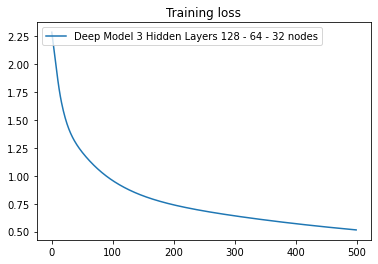

In [83]:
plot_loss(outputs=three_sec_training_results)

In [84]:
def evaluate_model(model, x_data, y_data, batch_size):
	dataset = GTZANDataset(x_data, y_data)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	model.eval()

	correct = 0
	pred = 0
    
	for x, y in dataloader:
		y_pred = model(x)

		y_pred_softmax = torch.log_softmax(y_pred, dim=1)
		_, y_pred_tags = torch.max(y_pred_softmax, dim=1)

		correct_pred = (y_pred_tags == y).float()
		correct += int(correct_pred.sum())
		pred += len(correct_pred)

	acc = correct / pred
	print(f"Accuracy: {round(acc * 100, 2)}")

In [85]:

for title, result in three_sec_training_results.items():
	model = result["model"]
	evaluate_model(model, x_3_train, y_3_train, batch_size=BATCH_SIZE)
	evaluate_model(model, x_3_test, y_3_test, batch_size=BATCH_SIZE)

Accuracy: 83.19
Accuracy: 78.8
